Вводная:
Трафовые пользователи - пользователи, привлеченные нами в результате рекламных кампаний, т.е. за каждого из них заплачено Х денег
Органические пользователи - пришли в проект сами, т.е. они для нас бесплатные
Есть подозрение, что часть органики приходит от купленного трафа (посредством внутренних виральных инструментов игры, word of mouth или какими-то другими способами).
Количество человек, пришедших с каждого пользователя будем условно называть "k-фактором".

# Задача 1: посчитать k-фактор от трафовых пользователей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
from scipy import stats
from sklearn.linear_model import LinearRegression
import datetime


import requests
from urllib.parse import urlencode

C:\Users\Ilya-\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

path_to_file = {
    'data':   ['https://disk.yandex.ru/d/PNCtTm3MQe5r2w', ',']
            }
for csv_filename, csv_link in path_to_file.items():
    final_url               = base_url + urlencode(dict(public_key=csv_link[0]))
    response                = requests.get(final_url)
    download_url            = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

In [3]:
data

,ms,cohort,user_cnt,gross
0,ORGANIC,2016-01-01,3676,1510
1,UA,2016-01-01,6061,686
2,UA,2016-01-02,6542,1179
3,ORGANIC,2016-01-02,3875,565
4,ORGANIC,2016-01-03,3699,425
...,...,...,...,...
1457,UA,2017-12-29,4180,65
1458,ORGANIC,2017-12-30,5651,17
1459,UA,2017-12-30,4291,13
1460,UA,2017-12-31,3743,25


In [4]:
data.isna().sum()

ms          0
cohort      0
user_cnt    0
gross       0
dtype: int64

In [5]:
data.describe()

,user_cnt,gross
count,1462.000000,1462.000000
mean,6201.270862,516.803010
std,4058.405863,449.168427
min,2085.000000,12.000000
25%,3763.000000,229.000000
50%,4723.000000,418.500000
75%,7253.250000,698.750000
max,41110.000000,8214.000000


In [6]:
data.ms.unique()

array(['ORGANIC', 'UA'], dtype=object)

In [7]:
data.sort_values(['cohort'])

,ms,cohort,user_cnt,gross
0,ORGANIC,2016-01-01,3676,1510
1,UA,2016-01-01,6061,686
2,UA,2016-01-02,6542,1179
3,ORGANIC,2016-01-02,3875,565
4,ORGANIC,2016-01-03,3699,425
...,...,...,...,...
1457,UA,2017-12-29,4180,65
1458,ORGANIC,2017-12-30,5651,17
1459,UA,2017-12-30,4291,13
1460,UA,2017-12-31,3743,25


Проанализровав данные, можно сделать вывод, что идентифицировать "чистых" приведенных клиентов от трафа не представляется возможным.
1. Нет данных о каналах привлечения (как пришел трафовый или органический пользователь?);
2. Нет данных о взаимосвязи клиента с клиентом (трафа с органикой).
По этой причине, в дальнейшем будем искать связь между двумя переменными - количество трафа и количество органики в разрезе одного дня. То есть мы предполагаем, что клиент из трафа приводит органического пользователя только в тот день, когда производит оплату

In [8]:
data.groupby(['ms']).user_cnt.describe()

,count,mean,std,min,25%,50%,75%,max
ms,,,,,,,,
ORGANIC,731.0,4707.459644,2152.880856,2326.0,3549.0,4222.0,5186.0,22057.0
UA,731.0,7695.082079,4884.662254,2085.0,4176.5,6538.0,9643.5,41110.0


Создадим отдельный датафрейм с данными для расчёта соотношения трафа к органике

In [9]:
df = pd.merge(data.query("ms == 'UA'").groupby(['cohort'], as_index = False).agg({'user_cnt' : 'sum'}).rename(columns = {'user_cnt' : 'UA_cnt'}),
          data.query("ms == 'ORGANIC'").groupby(['cohort'], as_index = False).agg({'user_cnt' : 'sum'}).rename(columns = {'user_cnt' : 'ORG_cnt'}))
df['share'] = df.UA_cnt / df.ORG_cnt

Посмотрим на основные параметры распредления доли трафа от органики и заметим, что данные имеют сильный разброс, поэтому для эталонного значения лучше использовать медиану.

In [10]:
df.share.describe()

count    731.000000
mean       1.624227
std        0.626958
min        0.229593
25%        1.141439
50%        1.566201
75%        2.109203
max        3.601821
Name: share, dtype: float64

In [11]:
k1 = df.share.describe()[5]

In [12]:
datetime.date(2016,1,1) + datetime.timedelta(days = 1)
x_date = []
min_date = datetime.date(2016,1,1)
while min_date < datetime.date(2018,1,1):
    x_date.append(str(min_date))
    min_date = min_date + datetime.timedelta(days = 30)

Пронаблюдаем определенную сезонность преобладания трафа над органическими пользователями (январь, июль) и наоборот (ноябрь)

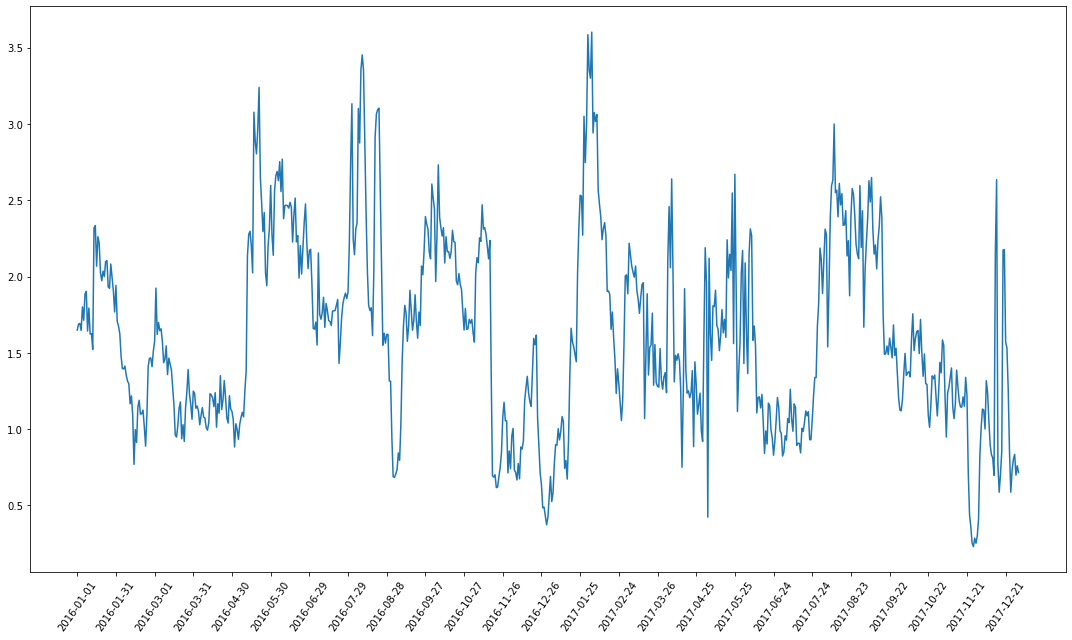

In [13]:
plt.figure(figsize=(15, 9))
plt.plot(df.cohort , df.share)
plt.xticks(x_date, rotation=55)
plt.tight_layout()
plt.show()

In [14]:
df.sort_values('share', ascending = False)

,cohort,UA_cnt,ORG_cnt,share
399,2017-02-03,16219,4503,3.601821
396,2017-01-31,15114,4216,3.584915
221,2016-08-09,15158,4390,3.452847
220,2016-08-08,14620,4358,3.354750
222,2016-08-10,20957,6249,3.353657
...,...,...,...,...
698,2017-11-29,3327,11111,0.299433
696,2017-11-27,3039,10654,0.285245
697,2017-11-28,2896,11504,0.251739
694,2017-11-25,3171,12606,0.251547


Также посчитаем какое среднее отношение имеют общее количество трафовых пользователей к органическим (без внимания на выбросы)

In [15]:
k2 = data.query("ms == 'UA'").agg({'user_cnt' : 'sum'})[0]/data.query("ms == 'ORGANIC'").agg({'user_cnt' : 'sum'})[0]
k2

1.6346570466352413

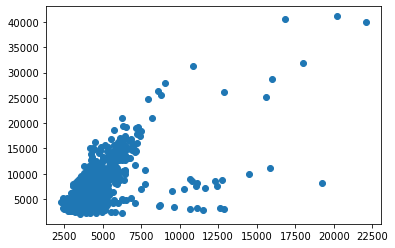

In [16]:
plt.scatter(data.query("ms == 'ORGANIC'").user_cnt, data.query("ms == 'UA'").user_cnt)

Из диаграммы зависимостей трафа и органики видно, что имеются выбросы и основная масса значений сосредоточена в правом нижнем углу, что говорит о малой эффективности использования линейной регрессии. Но справочно проанализруем получившееся уравнение зависимости органики от трафа.

In [17]:
model = LinearRegression()
model.fit(np.array(data.query("ms == 'ORGANIC'").user_cnt).reshape((-1, 1)), np.array(data.query("ms == 'UA'").user_cnt))

LinearRegression()

In [18]:
r_sq = model.score(np.array(data.query("ms == 'ORGANIC'").user_cnt).reshape((-1, 1)), np.array(data.query("ms == 'UA'").user_cnt))
print('Коэф детерминации:', r_sq)

Коэф детерминации: 0.40400807357444957


In [19]:
model.intercept_

906.2327230382871

In [20]:
k3 = model.coef_
k3

array([1.44214712])

Также можно посмотреть графики распределения количества пользователей и их траты в разрезе ms

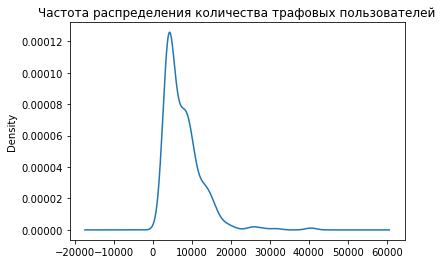

In [44]:
data.query("ms == 'UA'").user_cnt.plot.kde()
plt.title('Частота распределения количества трафовых пользователей') #Название
plt.show()

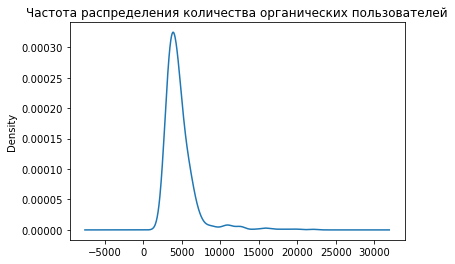

In [46]:
data.query("ms == 'ORGANIC'").user_cnt.plot.kde()
plt.title('Частота распределения количества органических пользователей') #Название
plt.show()

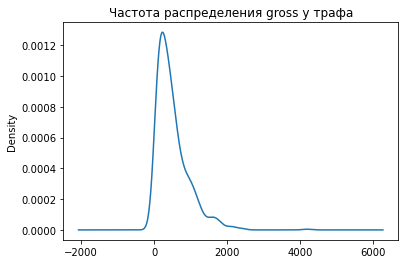

In [51]:
data.query("ms == 'UA'").gross.plot.kde()
plt.title('Частота распределения gross у трафа') #Название
plt.show()

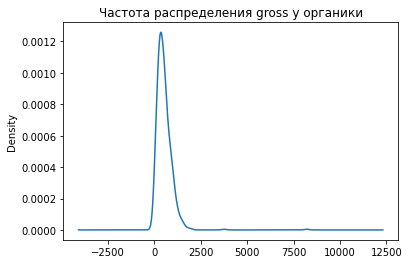

In [50]:
data.query("ms == 'ORGANIC'").gross.plot.kde()
plt.title('Частота распределения gross у органики') #Название
plt.show()

(array([0.07800084, 0.48635817, 0.79377324, 0.4175339 , 0.6561247 ,
        0.44506361, 0.36247449, 0.0596477 , 0.03211799, 0.02294142]),
 array([ 7.64252413,  7.94067239,  8.23882064,  8.5369689 ,  8.83511715,
         9.13326541,  9.43141366,  9.72956192, 10.02771017, 10.32585843,
        10.62400668]),
 <BarContainer object of 10 artists>)

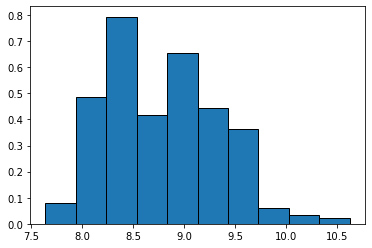

In [23]:
plt.hist(np.log(data.query("ms == 'UA'").user_cnt), density= True , edgecolor='black')

(array([0.00947912, 0.04739562, 0.09005169, 0.13981709, 0.25830615,
        0.38627434, 0.42182106, 0.28674353, 0.08531212, 0.00710934]),
 array([2.56494936, 3.14221322, 3.71947707, 4.29674093, 4.87400479,
        5.45126865, 6.02853251, 6.60579637, 7.18306023, 7.76032408,
        8.33758794]),
 <BarContainer object of 10 artists>)

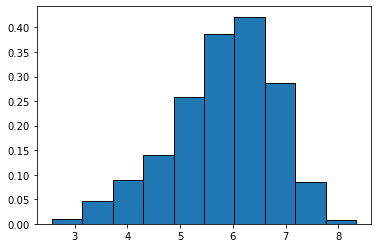

In [24]:
plt.hist(np.log(data.query("ms == 'UA'").gross), density= True , edgecolor='black')

In [48]:
stats.shapiro(np.log(data.query("ms == 'UA'").user_cnt))

ShapiroResult(statistic=0.9719459414482117, pvalue=1.2564031759421113e-10)

In [26]:
stats.shapiro(np.log(data.query("ms == 'UA'").gross))

ShapiroResult(statistic=0.9780324697494507, pvalue=5.068566011345865e-09)

Было предположение о логнормальном распределении трат и новых пользователях, но тест Шапиро-Уилка показал, что прологарифмированная выборка, как в случае с тратами, так и в случае с новыми пользователями говорит о том, что у нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения. И соотвественно, мы не можем утверждать, что наши распределения имеют логнормальный вид.

И так, мы имеем 3 коэффициента, которые отображают зависимость независимой переменной (количество новых клиентов трафа) и зависимой переменной (количество новых органических клиентов).
Остановимся на значении k1 (медиана в разрезе каждого дня) и примем его за среднее количество людей, которых приводит трафовый пользователь (k-фактор).

In [27]:
k_factors = k1
print(k_factors)

1.5662007623888183


В нашем случае, трафовый пользователь в среднем приводит 1,56 органического пользователя в день. К-фактор = 1,56

# 2) Если k-фактор отличен от 0, посчитать “k-фактор” для денег - т.е. сколько дополнительно денег приходит на каждый потраченный доллар трафового пользователя от привлеченной трафом органики

In [28]:
df_gross = pd.merge(data.query("ms == 'UA'").groupby(['cohort'], as_index = False).agg({'gross' : 'sum'}).rename(columns = {'gross' : 'UA_gross'}),
          data.query("ms == 'ORGANIC'").groupby(['cohort'], as_index = False).agg({'gross' : 'sum'}).rename(columns = {'gross' : 'ORG_gross'}))
df_gross['share'] = df_gross.UA_gross / df_gross.ORG_gross

In [29]:
df_gross.share.describe()

count    731.000000
mean       1.128107
std        0.867538
min        0.034210
25%        0.546771
50%        0.922156
75%        1.428739
max        6.060377
Name: share, dtype: float64

In [30]:
data.query("ms == 'UA'").gross.describe()

count     731.000000
mean      504.846785
std       443.059257
min        13.000000
25%       190.000000
50%       377.000000
75%       673.000000
max      4178.000000
Name: gross, dtype: float64

In [31]:
data.query("ms == 'ORGANIC'").gross.describe()

count     731.000000
mean      528.759234
std       455.184716
min        12.000000
25%       268.000000
50%       456.000000
75%       711.000000
max      8214.000000
Name: gross, dtype: float64

(array([1.31707950e-03, 6.50328531e-04, 2.95603878e-04, 7.22587257e-05,
        4.26983379e-05, 1.97069252e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.28448753e-06]),
 array([  13. ,  429.5,  846. , 1262.5, 1679. , 2095.5, 2512. , 2928.5,
        3345. , 3761.5, 4178. ]),
 <BarContainer object of 10 artists>)

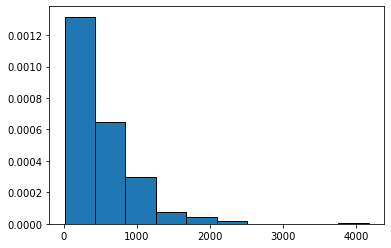

In [32]:
plt.hist(data.query("ms == 'UA'").gross, density= True , edgecolor='black')

(array([1.00405927e-03, 2.06816195e-04, 5.00361762e-06, 0.00000000e+00,
        1.66787254e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.66787254e-06]),
 array([  12. ,  832.2, 1652.4, 2472.6, 3292.8, 4113. , 4933.2, 5753.4,
        6573.6, 7393.8, 8214. ]),
 <BarContainer object of 10 artists>)

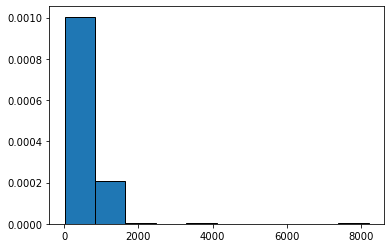

In [33]:
plt.hist(data.query("ms == 'ORGANIC'").gross, density= True , edgecolor='black')

Исходя из распределения трат пользователей, видно, что разница квантилей q4-q3 у органики сильно выше, что говорит о больших выбросах, которые "тянут" соотношение трат трафа к органике вниз. Аналогично с задачей выше, будем опираться на медиану

In [34]:
df_gross.sort_values('UA_gross', ascending = False)

,cohort,UA_gross,ORG_gross,share
9,2016-01-10,4178,815,5.126380
22,2016-01-23,2403,571,4.208406
155,2016-06-04,2382,681,3.497797
182,2016-07-01,2150,772,2.784974
29,2016-01-30,2145,1438,1.491655
...,...,...,...,...
730,2017-12-31,25,20,1.250000
715,2017-12-16,20,85,0.235294
699,2017-11-30,20,42,0.476190
704,2017-12-05,19,102,0.186275


In [35]:
df_gross.sort_values('ORG_gross', ascending = False)

,cohort,UA_gross,ORG_gross,share
237,2016-08-25,281,8214,0.034210
489,2017-05-04,525,3743,0.140262
7,2016-01-08,915,1959,0.467075
15,2016-01-16,1740,1868,0.931478
44,2016-02-14,842,1751,0.480868
...,...,...,...,...
730,2017-12-31,25,20,1.250000
708,2017-12-09,69,17,4.058824
729,2017-12-30,13,17,0.764706
716,2017-12-17,25,13,1.923077


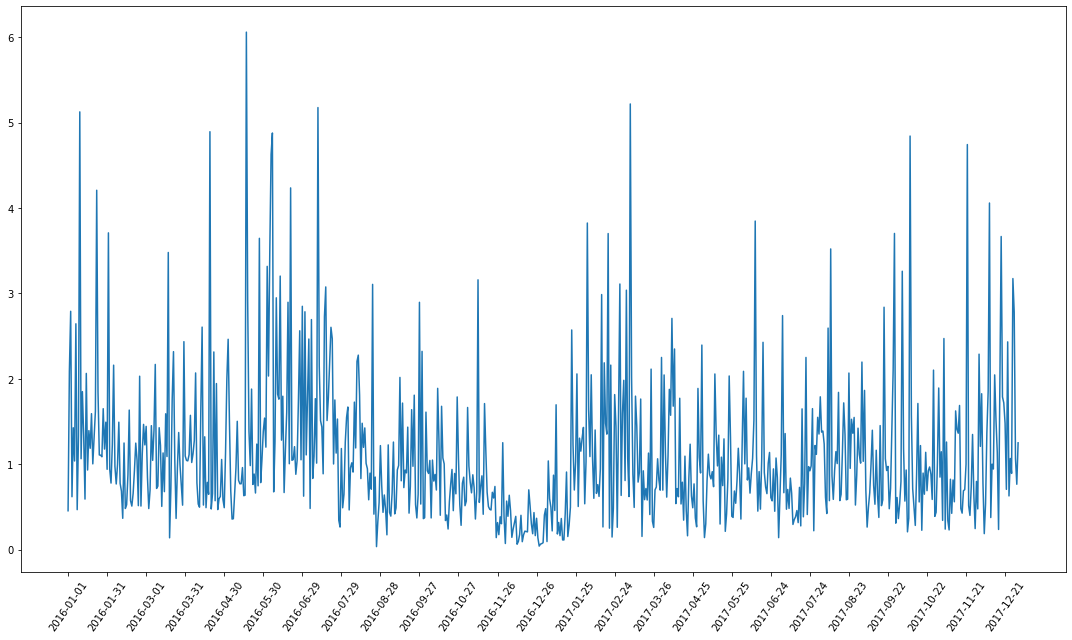

In [36]:
plt.figure(figsize=(15, 9))
plt.plot(df_gross.cohort , df_gross.share)
plt.xticks(x_date, rotation=55)
plt.tight_layout()
plt.show()

In [37]:
k_factors_gross = df_gross.share.describe()[5]
k_factors_gross

0.9221556886227545

На каждый потраченный доллар одного трафового пользователя в медианном смысле приходится 92,2 цента одного органического пользователя

# Задача 3: творческая. Если что-то интересное придет в голову или будет найдена полезная закономерность в данных - это приветствуется.

В этом блоке предлагаю проанализировать определенную сезонность или аномалии в количестве клиентов, воспользовавшись уже имеющимся датафреймом с долей трафа к органике

In [38]:
df

,cohort,UA_cnt,ORG_cnt,share
0,2016-01-01,6061,3676,1.648803
1,2016-01-02,6542,3875,1.688258
2,2016-01-03,6260,3699,1.692349
3,2016-01-04,5330,3237,1.646586
4,2016-01-05,5027,2792,1.800501
...,...,...,...,...
726,2017-12-27,5032,6276,0.801785
727,2017-12-28,4809,5763,0.834461
728,2017-12-29,4180,5987,0.698179
729,2017-12-30,4291,5651,0.759335


Сгруппируем и агрегируем данные по количеству новых пользователей для каждого дня (например, 1 января 2016 и 2017 года станут просто 1 января)

In [39]:
df['m_d'] = df.cohort.apply(lambda x: x.split('-')[-2] + '-' + x.split('-')[-1])

In [40]:
df.groupby('m_d', as_index = False).agg({'share' : 'mean'})

,m_d,share
0,01-01,1.099785
1,01-02,1.189074
2,01-03,1.108770
3,01-04,1.115309
4,01-05,1.288873
...,...,...
361,12-27,0.642627
362,12-28,0.661863
363,12-29,0.564238
364,12-30,0.566161


In [41]:
#даты для графика
dm = []
min_date = datetime.date(2016,1,1)
while min_date < datetime.date(2017,1,1):
    dm.append(str(min_date).split('-')[-2] + '-' +str(min_date).split('-')[-1])
    min_date = min_date + datetime.timedelta(days = 7)

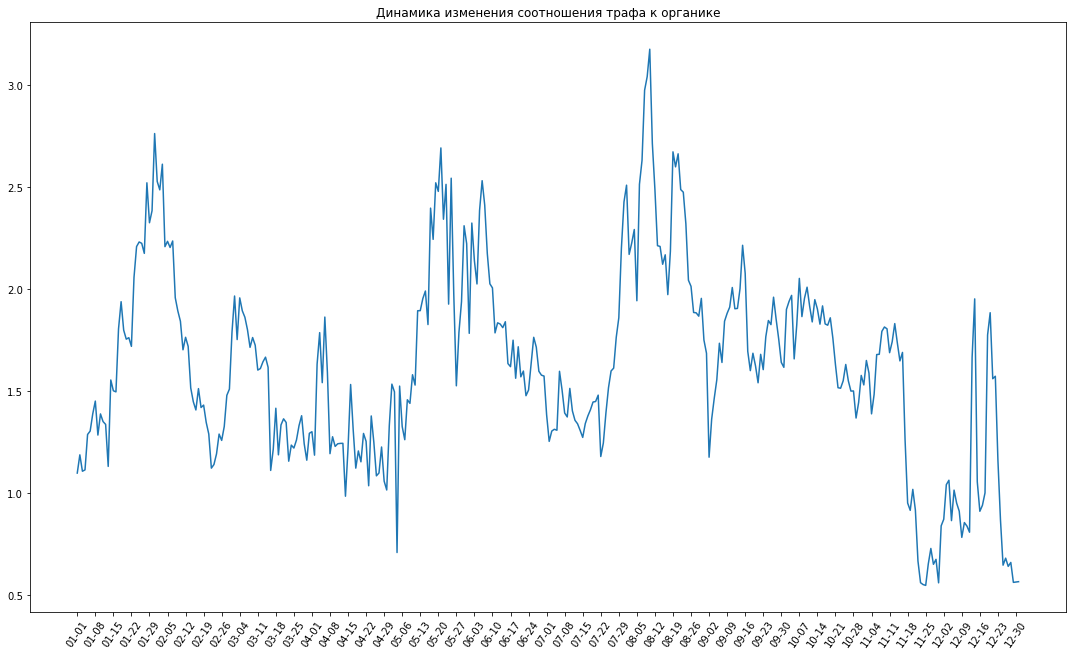

In [52]:
plt.figure(figsize=(15, 9))
plt.plot(df.groupby('m_d', as_index = False).agg({'share' : 'mean'}).m_d , df.groupby('m_d', as_index = False).agg({'share' : 'mean'}).share)
plt.xticks(dm, rotation=55)
plt.tight_layout()
plt.title('Динамика изменения соотношения трафа к органике')
plt.show()

In [43]:
df.groupby('m_d', as_index = False).agg({'share' : 'mean'}).sort_values('share', ascending = False)

,m_d,share
222,08-10,3.176620
221,08-09,3.042093
220,08-08,2.975766
30,01-31,2.763346
223,08-11,2.714703
...,...,...
363,12-29,0.564238
327,11-23,0.562632
334,11-30,0.561989
328,11-24,0.553411


Из последней таблицы можно выделить даты сезонного преобладания трафа над органикой (доля максимальна), и наоборот (доля минимальна)

In [245]:
df.query("cohort == '2016-08-10' or cohort == '2017-08-10'")

,cohort,UA_cnt,ORG_cnt,share,m_d
222,2016-08-10,20957,6249,3.353657,08-10
587,2017-08-10,14425,4809,2.999584,08-10
